The columns `user_activity_1` and `user_activity_2` are missing in the test set. They describe the user activity on the website and correlate with the target variable `orders`. Especially `user_activity_2` has a very high correlation score. In this notebook I will try to predict the `user_activity_2` column with Prophet and use it as a feature for my main model. Therefore I will use ensemble voting. 

Special thanks goes to [MOUADENNA](https://www.kaggle.com/code/mouadenna/prophet-rohlik-sample-submission-notebook/notebook) for providing a notebook for predicting the orders

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from category_encoders import OneHotEncoder, MEstimateEncoder, CatBoostEncoder
from sklearn import set_config
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, log_loss, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import warnings

import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)
plt.style.use('ggplot')

In [2]:
train = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train.csv')
test = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test.csv')

# Correlation

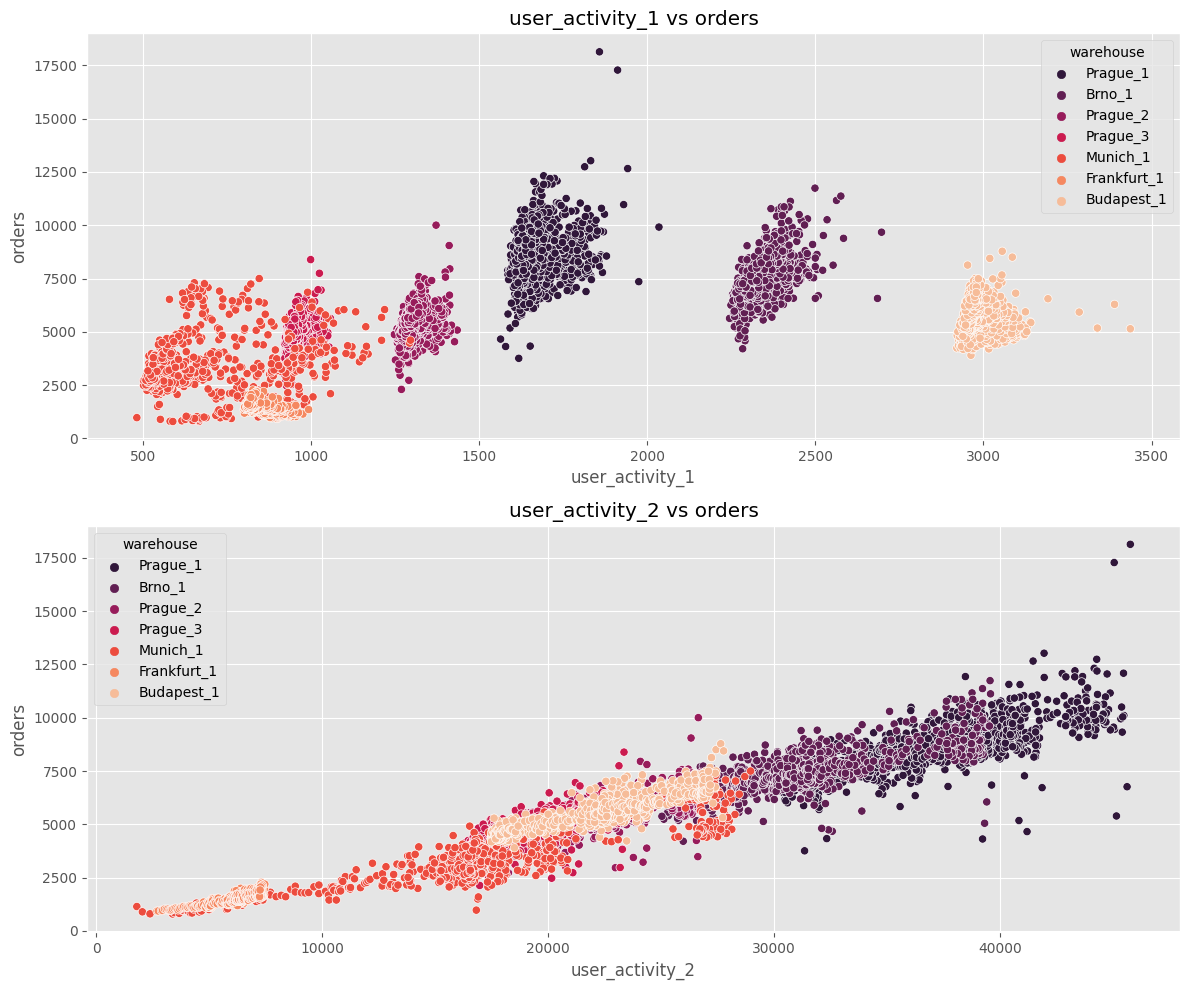

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
sns.scatterplot(ax=axes[0], data=train, x='user_activity_1', y='orders', hue='warehouse', palette='rocket')
axes[0].set_title('user_activity_1 vs orders')
sns.scatterplot(ax=axes[1], data=train, x='user_activity_2', y='orders', hue='warehouse', palette='rocket')
axes[1].set_title('user_activity_2 vs orders')
plt.tight_layout()
plt.show();

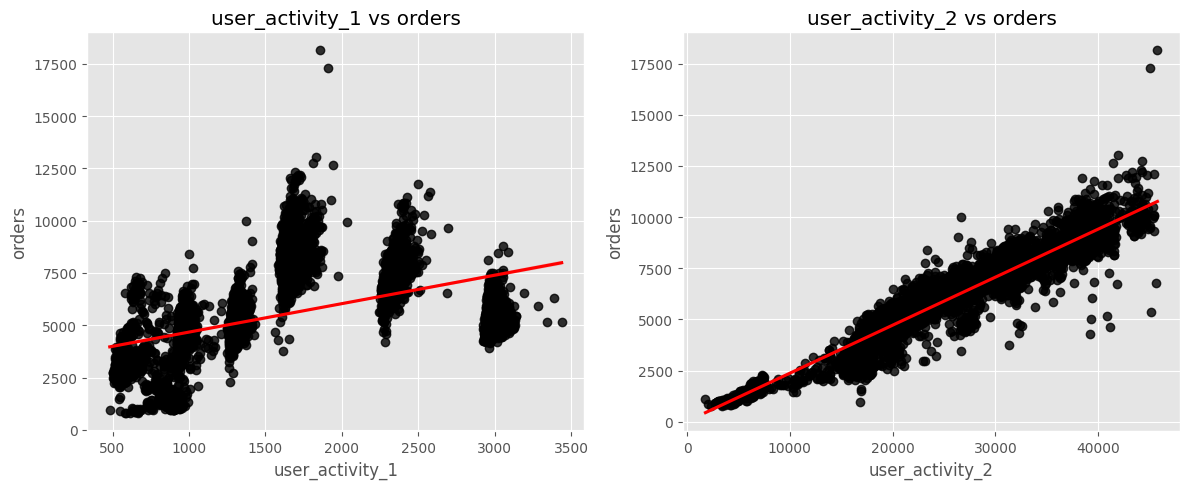

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.regplot(ax=axes[0], data=train, x='user_activity_1', y='orders', scatter_kws={"color": "black"}, line_kws={"color": "red"})
axes[0].set_title('user_activity_1 vs orders')
sns.regplot(ax=axes[1], data=train, x='user_activity_2', y='orders', scatter_kws={"color": "black"}, line_kws={"color": "red"})
axes[1].set_title('user_activity_2 vs orders')
plt.tight_layout()
plt.show();

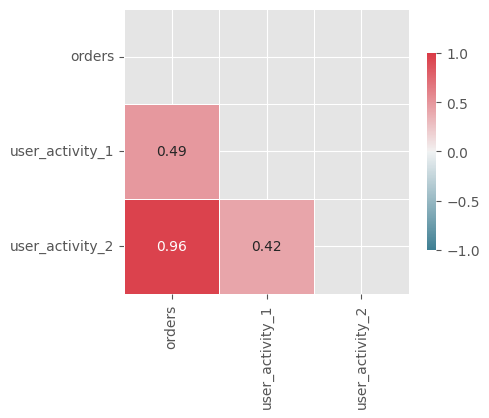

In [5]:
corr = train[['orders', 'user_activity_1', 'user_activity_2']].corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

# Time Series

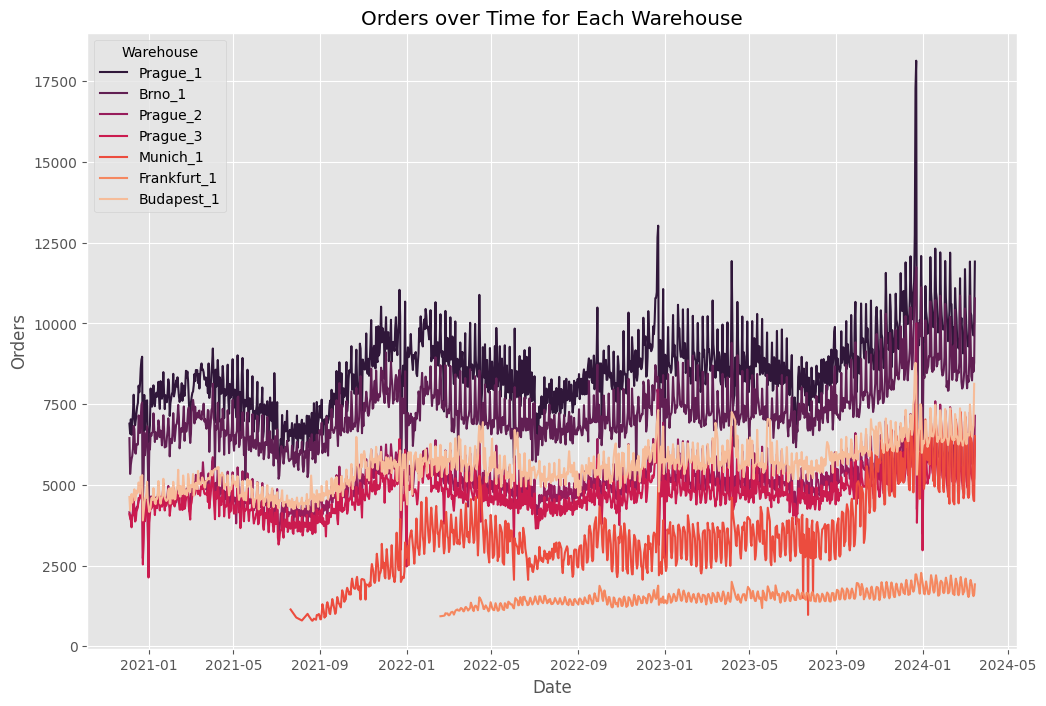

In [6]:
train['date'] = pd.to_datetime(train['date'])
plt.figure(figsize=(12, 8))
sns.lineplot(data=train, x='date', y='orders', hue='warehouse', palette='rocket')
plt.title('Orders over Time for Each Warehouse')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend(title='Warehouse')
plt.show();

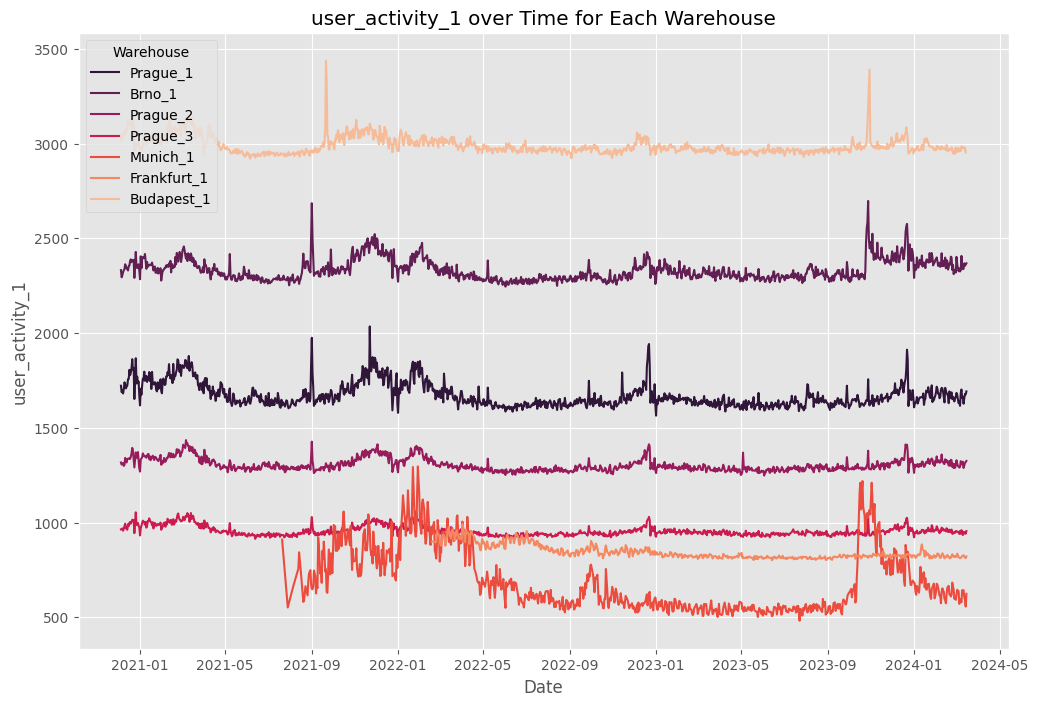

In [7]:
train['date'] = pd.to_datetime(train['date'])
plt.figure(figsize=(12, 8))
sns.lineplot(data=train, x='date', y='user_activity_1', hue='warehouse', palette='rocket')
plt.title('user_activity_1 over Time for Each Warehouse')
plt.xlabel('Date')
plt.ylabel('user_activity_1')
plt.legend(title='Warehouse')
plt.show();

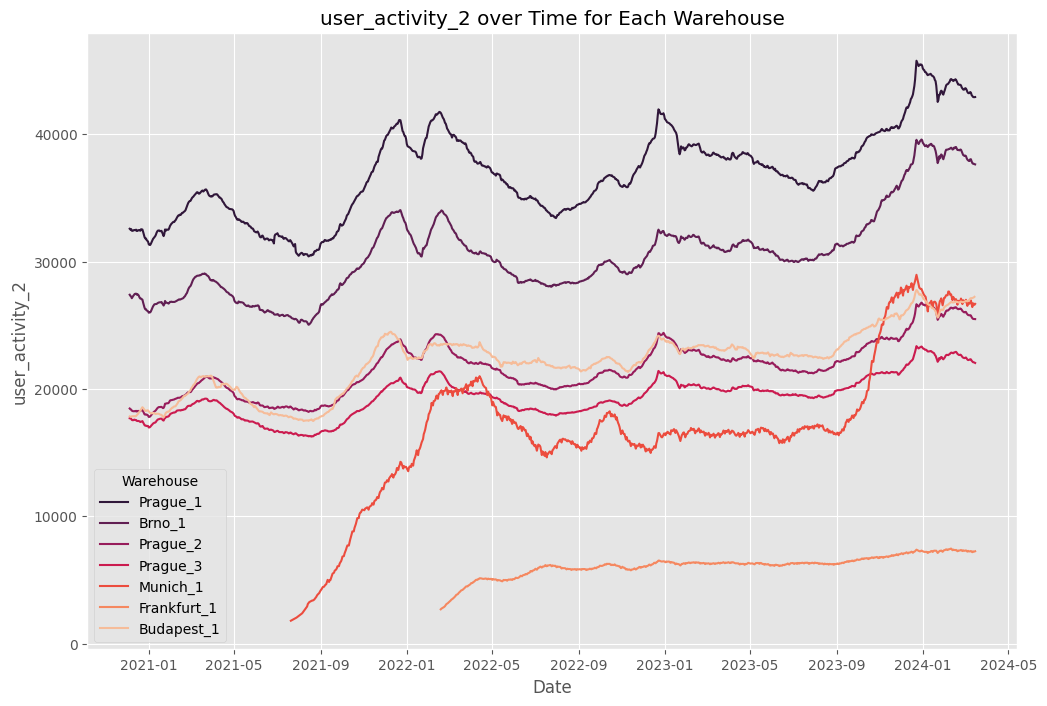

In [8]:
train['date'] = pd.to_datetime(train['date'])
plt.figure(figsize=(12, 8))
sns.lineplot(data=train, x='date', y='user_activity_2', hue='warehouse', palette='rocket')
plt.title('user_activity_2 over Time for Each Warehouse')
plt.xlabel('Date')
plt.ylabel('user_activity_2')
plt.legend(title='Warehouse')
plt.show();

# Preprocessing for Prophet

Credit goes to [mouadenna](https://www.kaggle.com/code/mouadenna/prophet-rohlik-sample-submission-notebook) for the following code.

In [9]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [10]:
def transform_data(df):
    df['holiday_name'] = df['holiday_name'].fillna('').astype('category')
    df['warehouse'] = df['warehouse'].astype('category')
    
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['season'] = (df['month'] % 12 + 3) // 3
    df['season'] = df['season'].astype(int)
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['day_before_holiday'] = df['holiday'].shift().fillna(0)
    df['day_after_holiday'] = df['holiday'].shift(-1).fillna(0)
    df['day_before_school_holiday'] = df['school_holidays'].shift().fillna(0)
    df['day_after_school_holiday'] = df['school_holidays'].shift(-1).fillna(0)
    df['holiday_and_shops_closed'] = df['holiday'] * df['shops_closed']
    
    df['week_before_holiday'] = df['holiday'].shift(-7).rolling(window=7, min_periods=1).sum().shift(1).fillna(0).apply(lambda x: 1 if x > 0 else 0)
    df['week_after_holiday'] = df['holiday'].shift(7).rolling(window=7, min_periods=1).sum().shift(-1).fillna(0).apply(lambda x: 1 if x > 0 else 0)

    return df

train=transform_data(train)
test=transform_data(test)

In [11]:
combined_df = pd.concat([train, test])

In [12]:
categories = train.warehouse.unique()

category_data_sets = {}

def split_data(df, category):
    category_data = df[df['warehouse'] == category]
    
    split_date = '2024-03-16'
    split_date = pd.to_datetime(split_date)
    
    data_train = category_data[category_data['date'] < split_date].copy()
    data_test = category_data[(category_data['date'] >= split_date)].copy()
    
    # Store the training and testing sets in the dictionary
    category_data_sets[f"{category}_train"] = data_train
    category_data_sets[f"{category}_test"] = data_test

for category in categories:
    split_data(combined_df, category)

In [13]:
category_data_sets['Prague_1_train']
category_data_sets['Prague_1_test']
category_data_sets['Brno_1_train']
category_data_sets['Brno_1_test']
category_data_sets['Prague_2_train']
category_data_sets['Prague_2_test']
category_data_sets['Prague_3_train']
category_data_sets['Prague_3_test']
category_data_sets['Munich_1_train']
category_data_sets['Munich_1_test']
category_data_sets['Frankfurt_1_train']
category_data_sets['Frankfurt_1_test']
category_data_sets['Budapest_1_train']
category_data_sets['Budapest_1_test']
print('')

# Predict user_activity_2

In [14]:
class ForecastModel:
    def __init__(self, category):
        self.category = category
        self.category_data_sets = category_data_sets
        self.model = None
        self.train_prophet = None
        self.test_fcst = None
        self.data_train = None
        self.data_test = None
    
    def prepare_data(self):
        temp = pd.concat([self.category_data_sets[f'{self.category}_train'], self.category_data_sets[f'{self.category}_test']])
        
        holiday_df = temp[['date', 'holiday_name']][temp['holiday_name'].apply(len) > 1]
        holiday_df.rename(columns={'date': 'ds', 'holiday_name': 'holiday'}, inplace=True)
        
        self.train_prophet = self.category_data_sets[f'{self.category}_train'].reset_index(drop=True) \
            .rename(columns={'date': 'ds', 'user_activity_2': 'y'})

        # Initialize the Prophet model
        self.model = Prophet(yearly_seasonality=True,weekly_seasonality=True, holidays=holiday_df, seasonality_prior_scale=16)
        self.model.add_regressor('week_after_holiday')
        self.model.add_regressor('week_before_holiday')
        self.model.add_regressor('holiday_and_shops_closed')

    def fit_model(self):
        self.model.fit(self.train_prophet)

    def make_predictions(self):
        test_prophet = self.category_data_sets[f'{self.category}_test'].reset_index(drop=True) \
            .rename(columns={'date': 'ds', 'user_activity_2': 'y'})

        self.test_fcst = self.model.predict(test_prophet)
    
    def plot_forecast(self):
        fig, ax = plt.subplots(figsize=(10, 5))
        self.model.plot(self.test_fcst, ax=ax)
        ax.set_title(f'Prophet Forecast for category {self.category}')
        plt.show()

    def plot_predictions_vs_actual(self):
        self.data_train = self.category_data_sets[f'{self.category}_train']
        self.data_test = self.category_data_sets[f'{self.category}_test']

        fig, ax = plt.subplots(figsize=(10, 5))
        print(self.data_test.index)
        ax.scatter(self.data_test.index, self.data_test['user_activity_2'], color='r', label='Actual Test Orders')
        ax.scatter(self.data_train.index, self.data_train['user_activity_2'], color='k', label='Actual Train Orders')
        ax.scatter(self.test_fcst.ds, self.test_fcst['yhat_upper'], color='b', label='Predicted Orders')
        ax.set_title('Predictions vs Actual')
        plt.legend()
        plt.show()

    def calculate_mape(self):
        mape = mean_absolute_percentage_error(self.data_test['user_activity_2'], self.test_fcst['yhat_upper'])
        return mape

    def run(self):
        self.prepare_data()
        self.fit_model()
        self.make_predictions()
        self.plot_forecast()
        
    def compare(self):
        self.prepare_data()
        self.fit_model()
        self.make_predictions()
        self.plot_forecast()
        self.plot_predictions_vs_actual()

        return self.calculate_mape()

In [15]:
cats=train.warehouse.unique()

10:00:56 - cmdstanpy - INFO - Chain [1] start processing
10:00:57 - cmdstanpy - INFO - Chain [1] done processing


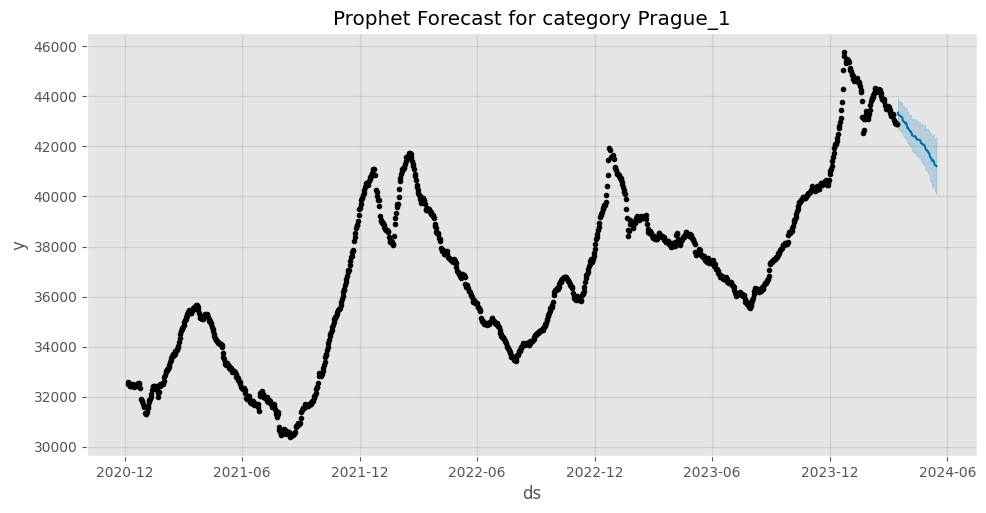

10:00:58 - cmdstanpy - INFO - Chain [1] start processing
10:00:59 - cmdstanpy - INFO - Chain [1] done processing


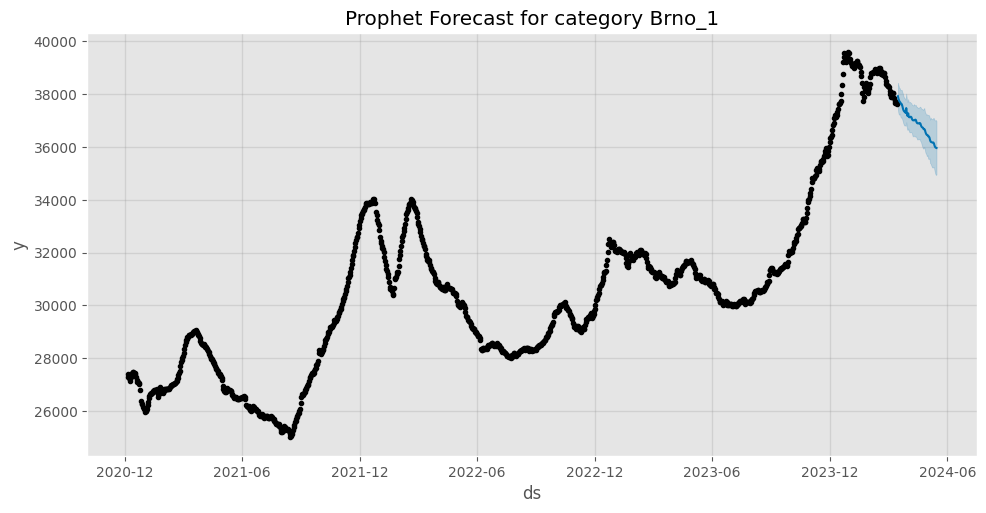

10:01:00 - cmdstanpy - INFO - Chain [1] start processing
10:01:02 - cmdstanpy - INFO - Chain [1] done processing


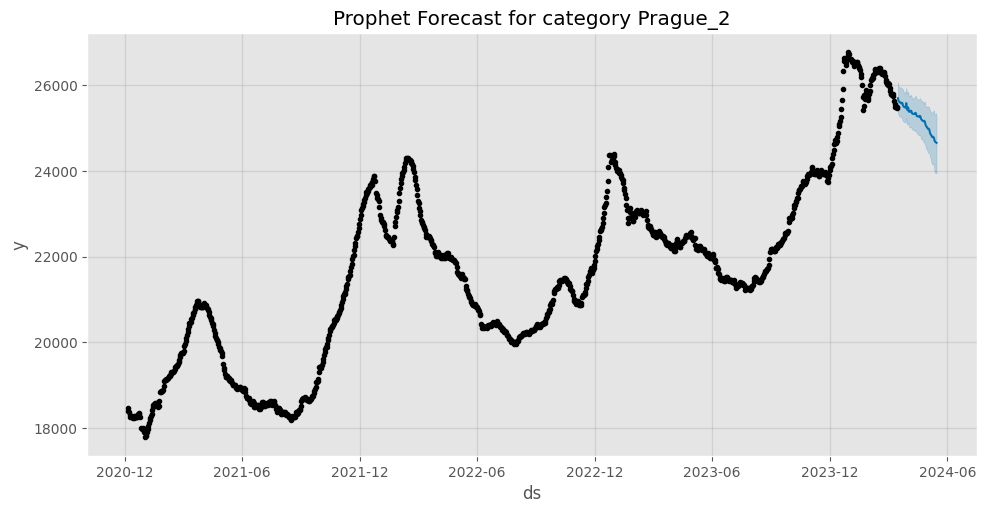

10:01:03 - cmdstanpy - INFO - Chain [1] start processing
10:01:04 - cmdstanpy - INFO - Chain [1] done processing


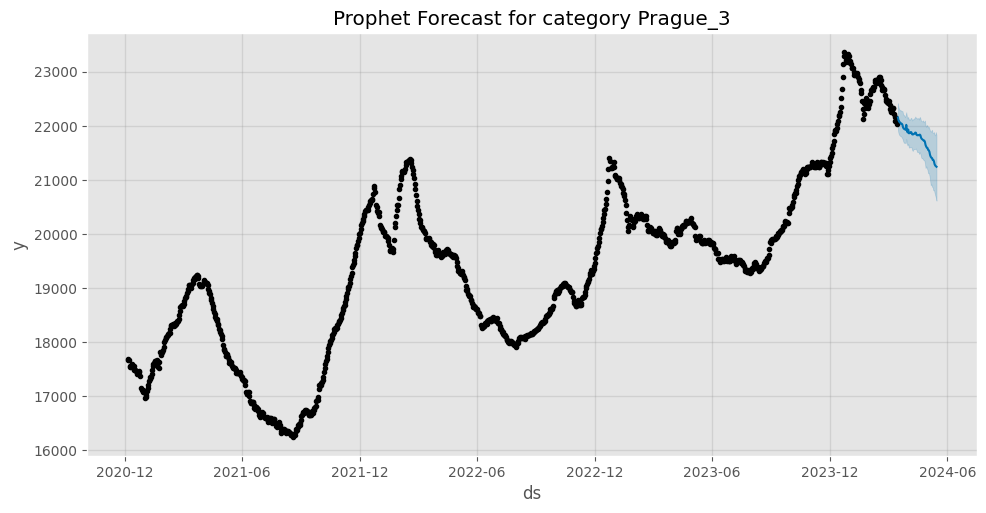

10:01:05 - cmdstanpy - INFO - Chain [1] start processing
10:01:07 - cmdstanpy - INFO - Chain [1] done processing


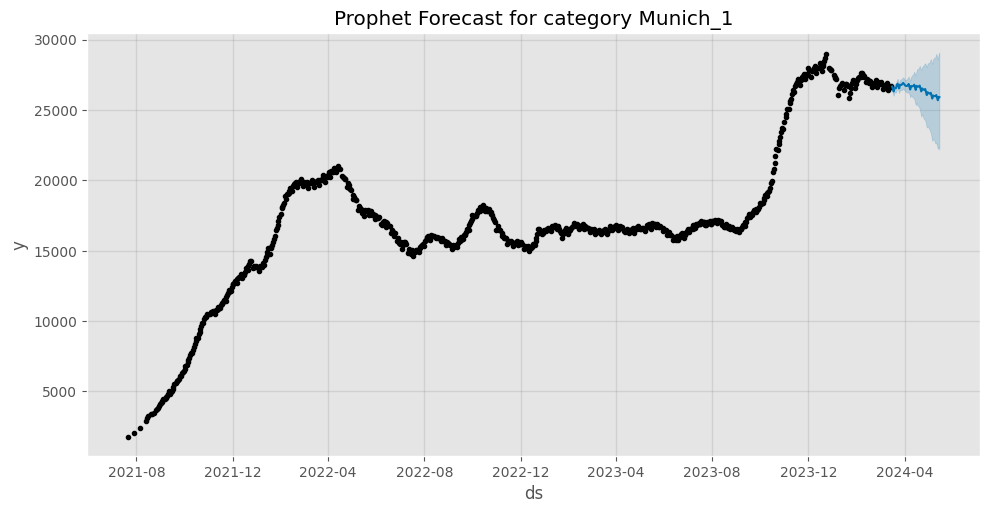

10:01:07 - cmdstanpy - INFO - Chain [1] start processing
10:01:09 - cmdstanpy - INFO - Chain [1] done processing


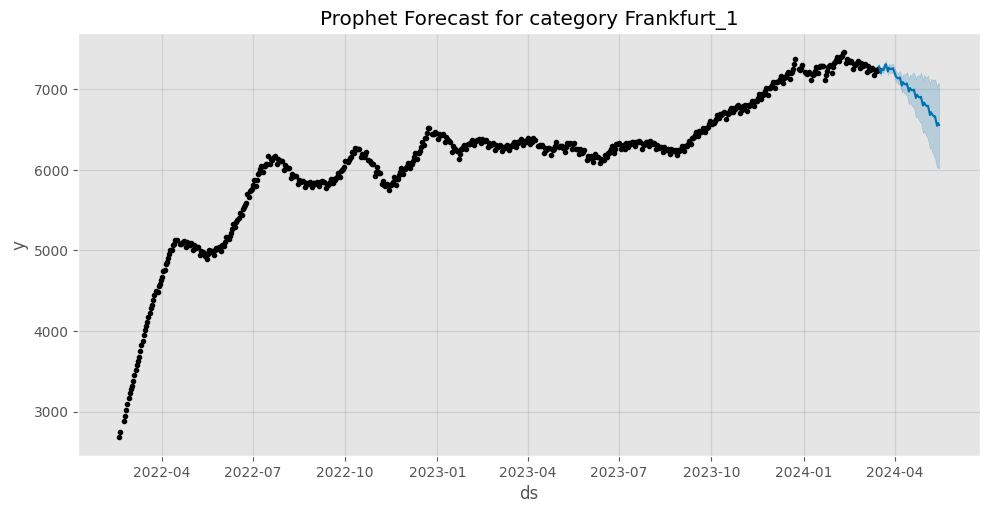

10:01:09 - cmdstanpy - INFO - Chain [1] start processing
10:01:10 - cmdstanpy - INFO - Chain [1] done processing


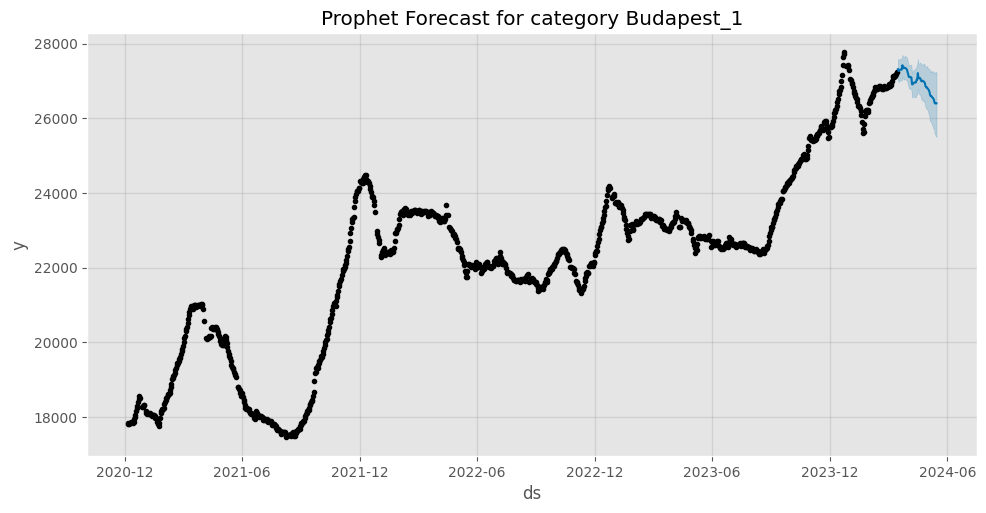

In [16]:
user_activity_two_df = pd.DataFrame(columns=['id', 'user_activity_2'])
for cat in cats:
    model = ForecastModel(cat)
    model.run()
    id_sub=model.test_fcst['ds'].dt.date.apply(lambda x: f"{cat}_{x}")
    orders=model.test_fcst['yhat_upper']
    temp_df = pd.DataFrame({'id': id_sub, 'user_activity_2': orders})
    user_activity_two_df = pd.concat([user_activity_two_df, temp_df], ignore_index=True)

In [17]:
user_activity_two_df = user_activity_two_df.set_index('id')

# Preprocessing for Ensemble
Credit goes to [Sheikh Muhammad Abdullah](https://www.kaggle.com/abdmental01) in his [notebook](https://www.kaggle.com/code/abdmental01/rohlik-starter-v1) for the following function

In [18]:
train = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test.csv', index_col = 'id')

In [19]:
test = pd.concat([test, user_activity_two_df], axis=1)
test

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,user_activity_2
id,,,,,,,,
Prague_1_2024-03-16,Prague_1,2024-03-16,NaN,0,0,0,0,43950.420648
Prague_1_2024-03-17,Prague_1,2024-03-17,NaN,0,0,0,0,43784.989268
Prague_1_2024-03-18,Prague_1,2024-03-18,NaN,0,0,0,0,43817.800907
Prague_1_2024-03-19,Prague_1,2024-03-19,NaN,0,0,0,0,43846.650689
Prague_1_2024-03-20,Prague_1,2024-03-20,NaN,0,0,0,0,43786.604213
...,...,...,...,...,...,...,...,...
Budapest_1_2024-05-11,Budapest_1,2024-05-11,NaN,0,0,0,0,27213.838004
Budapest_1_2024-05-12,Budapest_1,2024-05-12,NaN,0,0,0,0,27234.590608
Budapest_1_2024-05-13,Budapest_1,2024-05-13,NaN,0,0,0,0,27190.864502


In [20]:
data = pd.concat([train, test], axis=0)

In [21]:
data['holiday_name'] = data['holiday_name'].fillna('None')

In [22]:
# Dictionary mapping cities to their countries
city_to_country = {
    'Munich_1': 'Germany',
    'Frankfurt_1': 'Germany',
    'Budapest_1': 'Hungary',
    'Brno_1': 'Czech Republic',
    'Prague_1': 'Czech Republic',
    'Prague_2': 'Czech Republic',
    'Prague_3': 'Czech Republic'
}

data['country'] = data['warehouse'].map(city_to_country)

In [23]:
def Process_Date(Df):
    Df['date'] = pd.to_datetime(Df['date'])
    Df['year'] = Df['date'].dt.year
    Df['day'] = Df['date'].dt.day
    Df['month'] = Df['date'].dt.month
    Df['quarter'] = Df['date'].dt.quarter
    Df['month_name'] = Df['date'].dt.month_name()
    Df['day_of_week'] = Df['date'].dt.day_name()
    Df['week'] = Df['date'].dt.isocalendar().week
    
    Df['year_sin'] = np.sin(2 * np.pi * Df['year'])
    Df['year_cos'] = np.cos(2 * np.pi * Df['year'])
    Df['month_sin'] = np.sin(2 * np.pi * Df['month'] / 12) 
    Df['month_cos'] = np.cos(2 * np.pi * Df['month'] / 12)
    Df['day_sin'] = np.sin(2 * np.pi * Df['day'] / 31)  
    Df['day_cos'] = np.cos(2 * np.pi * Df['day'] / 31)
    Df['quarter_sin'] = np.sin(2 * np.pi * Df['quarter'] / 4)
    Df['quarter_cos'] = np.cos(2 * np.pi * Df['quarter'] / 4)
    
    Df['group']=(Df['year']-2020)*48+Df['month']*4+Df['day']//7
    Df['total_holidays_month'] = Df.groupby(['year', 'month'])['holiday'].transform('sum')
    Df['total_shops_closed_week'] = Df.groupby(['year', 'week'])['shops_closed'].transform('sum')
    Df['group_sin'] = np.sin(2 * np.pi * Df['group'] / Df['group'].max())
    Df['group_cos'] = np.cos(2 * np.pi * Df['group'] / Df['group'].max())
    return Df

In [24]:
data = Process_Date(data)

In [25]:
# Use only columns we have also in test set
data = data[['warehouse', 'date', 'holiday_name', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'year', 'day', 'month',
       'month_name', 'day_of_week', 'week', 'year_sin', 'year_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'group',
       'total_holidays_month', 'total_shops_closed_week',
       'group_sin', 'group_cos', 'country', 'user_activity_2',
       'orders']]

In [26]:
def apply_tfidf_svd(df, text_column, max_features=1000, n_components=10):
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    vectors = vectorizer.fit_transform(df[text_column])
    svd = TruncatedSVD(n_components)
    x_sv = svd.fit_transform(vectors)
    tfidf_df = pd.DataFrame(x_sv)
    cols = [(text_column + "_tfidf_" + str(f)) for f in tfidf_df.columns.to_list()]
    tfidf_df.columns = cols
    df = df.reset_index(drop=True)
    df = pd.concat([df, tfidf_df], axis="columns")
    return df

In [27]:
data = apply_tfidf_svd(data,'holiday_name')
data = data.drop(columns=['holiday_name', 'date'])

In [28]:
# Source: https://www.kaggle.com/code/gkanamoto/ensemble-stacking-modified
data['holiday_before'] = data['holiday'].shift(1).fillna(0).astype(int)
data['holiday_after'] = data['holiday'].shift(-1).fillna(0).astype(int)

In [29]:
# Create dummy features
data = pd.get_dummies(data)

In [30]:
# Rebuild train and test
train = data[~data['orders'].isnull()]
test = data[data['orders'].isnull()]
test = test.drop(columns=['orders'])

In [31]:
print(f'Train Shape: {train.shape}')
print(f'Test Shape: {test.shape}')

Train Shape: (7340, 62)
Test Shape: (397, 61)


In [32]:
y = train['orders']
X = train.drop(columns=['orders'])

In [33]:
seed = 1702
np.random.seed(seed)
skf = KFold(random_state=seed, shuffle=True)

# Cross Validation

In [34]:
def cross_validation_score(estimator, cv, label=''):
    X = train.copy()
    y = X.pop('orders')
    train_scores, val_scores = [], []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        model = clone(estimator)
        
        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y[train_idx]
        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y[val_idx]
        
        model.fit(X_train, y_train)
        
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        
        
        train_score = mean_absolute_percentage_error(y_train, train_preds)
        val_score = mean_absolute_percentage_error(y_val, val_preds)
        
        train_scores.append(train_score)
        val_scores.append(val_score)
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    return val_scores

In [35]:
score_list, oof_list = pd.DataFrame(), pd.DataFrame()

models = [
    ('rf', RandomForestRegressor(random_state = seed)),
    ('xgb', XGBRegressor(random_state = seed)),
    ('lgb', LGBMRegressor(random_state = seed)),
    ('cb', CatBoostRegressor(random_state = seed, verbose = 0)),
    ('ad', AdaBoostRegressor(random_state = seed)),
    ('ex', ExtraTreesRegressor(random_state = seed)),
    ('gb', GradientBoostingRegressor(random_state = seed)),
    ('hgb', HistGradientBoostingRegressor(random_state = seed)),
    ('lir', LinearRegression())
]

In [36]:
for (label, model) in models:
    score_list[label] = cross_validation_score(estimator=model,
                                                                cv=skf,
                                                                label=label)

Val Score: 0.04180 ± 0.00153 | Train Score: 0.01547 ± 0.00011 | rf
Val Score: 0.03567 ± 0.00123 | Train Score: 0.01872 ± 0.00037 | xgb
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1156
[LightGBM] [Info] Number of data points in the train set: 5872, number of used features: 60
[LightGBM] [Info] Start training from score 5534.083617
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 5872, number of used features: 60
[LightGBM

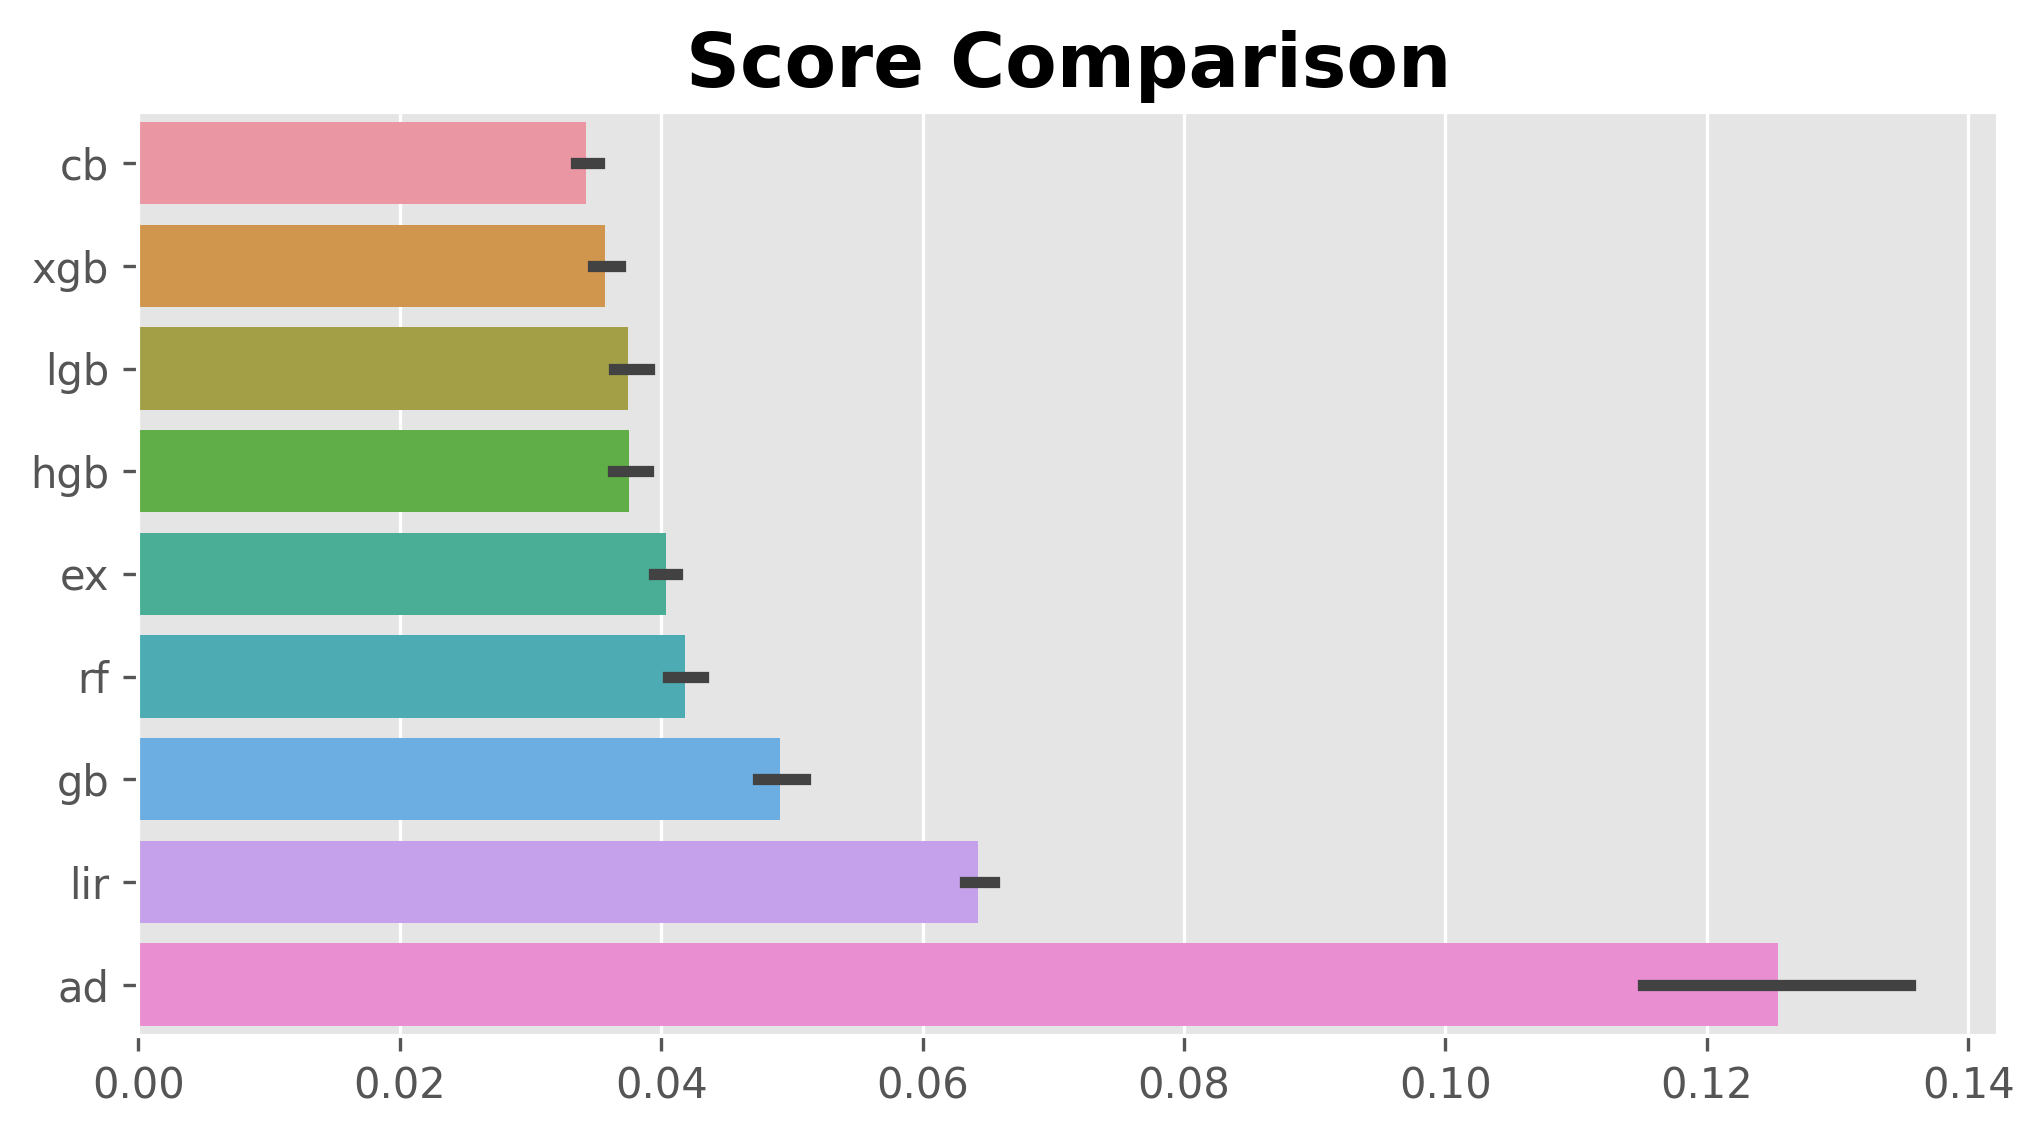

In [37]:
plt.figure(figsize = (8, 4), dpi = 300)
sns.barplot(data = score_list.reindex((-1 * score_list).mean().sort_values(ascending=False).index, axis = 1), orient = 'h')
plt.title('Score Comparison', weight = 'bold', size = 18)
plt.show()

# Voting

I will use the same models I used in my [Ensemble Voting Notebook](https://www.kaggle.com/code/mexwell/rohlik-orders-forecasting-ensemble-voting) so that I can compare the results better. 

In [38]:
# We use the best three models
voting = VotingRegressor(estimators=[
    ('cb', CatBoostRegressor(random_state = seed, verbose = 0)),
    ('xgb', XGBRegressor(random_state = seed)),
    ('hgb', HistGradientBoostingRegressor(random_state = seed))
])

In [39]:
_ = cross_validation_score(estimator=voting, cv=skf, label='voter')

Val Score: 0.03373 ± 0.00123 | Train Score: 0.02361 ± 0.00020 | voter


**Conclusion: The model does not get any better if we predict the user_activity_2 column beforehand and use it as a feature for the actual model.**

# Prediction and Submission

In [40]:
voting.fit(X,y)

VotingRegressor(estimators=[('cb',
                             <catboost.core.CatBoostRegressor object at 0x7db86488f550>),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,...
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=1702, ...)),
                            ('hgb',
                             HistGradientBoostingRegressor(random_state=1702))])

In [41]:
submission = test.copy()

In [42]:
preds = voting.predict(submission)

In [43]:
submission['orders'] = preds

In [44]:
sub = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv', index_col='id')
sub['orders'] = preds
sub

,orders
id,
Prague_1_2024-03-16,10709.146924
Prague_1_2024-03-17,10239.636306
Prague_1_2024-03-18,10063.010934
Prague_1_2024-03-19,9901.418469
Prague_1_2024-03-20,9869.967455
...,...
Budapest_1_2024-05-11,7375.530272
Budapest_1_2024-05-12,7020.234243
Budapest_1_2024-05-13,7032.131709


In [45]:
sub[['orders']].to_csv('submission.csv')